<a href="https://colab.research.google.com/github/ChrizZhuang/marginalized_graph_kernel_protein/blob/main/Docking_0615.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the environment

In [1]:
!nvidia-smi

Tue Jun 15 01:26:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install pymatgen==2020.12.31
!pip install pymatgen==2019.11.11
!pip install --pre graphdot
!pip install gdown

In [4]:
%matplotlib inline
import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphdot
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
from graphdot.graph.reorder import rcm
from graphdot.kernel.marginalized import MarginalizedGraphKernel # https://graphdot.readthedocs.io/en/latest/apidoc/graphdot.kernel.marginalized.html
from graphdot.kernel.marginalized.starting_probability import Uniform
from graphdot.model.gaussian_process import (
    GaussianProcessRegressor,
    LowRankApproximateGPR
)
from graphdot.kernel.fix import Normalization
import graphdot.microkernel as uX
import ase.io

# for getting all file names into a list under a directory 
from os import listdir
# for getting file names that match certain pattern
import glob
import time

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
#cd gdrive/MyDrive/Google\ Colab/Covid-Data
%cd gdrive/MyDrive/Covid-Data/

/content/gdrive/.shortcut-targets-by-id/1wtzMcocuK8kPsz8K0ktjCZPkv567W6M2/Covid-Data


In [7]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1wtzMcocuK8kPsz8K0ktjCZPkv567W6M2/Covid-Data


## load the data

In [8]:
files  = ['uncharged_NSP15_6W01_A_3_H.Orderable_zinc_db_enaHLL.2col.csv.1.xz']
dataset = pd.read_pickle(files[0]) # length of each csv file is 100000

In [9]:
target = 'energy'
N_train = 1000
N_test = 2000

np.random.seed(0) # with the same seed, multiple runs can have the same selected index
train_sel = np.random.choice(len(dataset), N_train, replace=False)
test_sel = np.random.choice(np.setxor1d(np.arange(len(dataset)), train_sel), N_test, replace=False)
train = dataset.iloc[train_sel]
test = dataset.iloc[test_sel]

In [10]:
train.head()

,energy,smiles,graphs
3582,-2.874773,CN(Cc1nc(no1)c2cccc(c2)Br)C(=O)Nc3cccc(c3)OC,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
60498,-3.469760,CCOC(=O)c1ccc(c(c1)C)NC(=S)NCCOc2ccc(cc2)C,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
53227,-0.487984,Cc1ccc(cc1S(=O)(=O)Nc2ccccc2OC)NC(=O)c3nc4nc(c...,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
21333,-1.808283,COc1ccc(cc1OC)CCNC(=O)COc2ccc(cc2)[N@@](Cc3ccc...,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
3885,-2.457642,Cc1cc(ccc1NCc2ccc(c(c2OC)C)OC)Br,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."


### Baseline mode

In [11]:
gpr_base = GaussianProcessRegressor(
    # kernel is the covariance function of the gaussian process (GP)
    kernel=Normalization( # kernel equals to normalization -> normalizes a kernel using the cosine of angle formula, k_normalized(x,y) = k(x,y)/sqrt(k(x,x)*k(y,y))
        # graphdot.kernel.fix.Normalization(kernel), set kernel as marginalized graph kernel, which is used to calculate the similarity between 2 graphs
        # implement the random walk-based graph similarity kernel as Kashima, H., Tsuda, K., & Inokuchi, A. (2003). Marginalized kernels between labeled graphs. ICML
        MarginalizedGraphKernel( 
            # node_kernel - A kernelet that computes the similarity between individual nodes
            # uX - graphdot.microkernel - microkernels are positive-semidefinite functions between individual nodes and edges of graphs
            node_kernel=uX.Additive( # addition of kernal matrices: sum of k_a(X_a, Y_a) cross for a in features
                # uX.Constant - a kernel that returns a constant value, always mutlipled with other microkernels as an adjustable weight
                #   c, the first input arg. as 0.5, (0.01, 10) the lower and upper bounds of c that is allowed to vary during hyperpara. optimizartion
                # uX.KroneckerDelta - a kronecker delta returns 1 when two features are equal and return h (the first input arg here, which is 0.5 in this case) otherwise
                #   (0.1, 0.9) the lower and upper bounds that h is allowed to vary during hyperpara. optimization
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 2nd element of graphdot.graph.Graph.nodes
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)), # the 3rd element of graphdot.graph.Graph.nodes
                # uX.SquareExponential - Equ. 26 in the paper
                # input arg. length_sacle is a float32, set as 1 in this case, which correspond to approx. 1 of the kernal value. 
                # This is used to determins how quicklys should the kernel decay to zero.
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0), # the 4th element of graphdot.graph.Graph.nodes
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 5th element of graphdot.graph.Graph.nodes
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0), # the 6th element of graphdot.graph.Graph.nodes
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 7th element of graphdot.graph.Graph.nodes
                # uX.Convolution - a convolutional microkernel which averages evaluations of a base microkernel between pairs pf elememts of two variable-length feature sequences
                # uX.KroneckerDelta as the base kernel
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9))) # the 8th element of graphdot.graph.Graph.nodes
            ).normalized,
            # edge_kernel - A kernelet that computes the similarity between individual edge
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 3rd element of graphdot.graph.Graph.nodes
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 4th element of graphdot.graph.Graph.nodes
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)), # the 5th element of graphdot.graph.Graph.nodes
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)), # the 6th element of graphdot.graph.Graph.nodes
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)) # the 7th element of graphdot.graph.Graph.nodes
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'), # the strating probability of the random walk on each node
            q=0.05 # the probability for the random walk to stop during each step
        )
    ),
    alpha=1e-4, # value added to the diagonal of the kernel matrix during fitting
    optimizer=True, # default optimizer of L-BFGS-B based on scipy.optimize.minimize
    normalize_y=True, # normalize the y values so taht the means and variance is 0 and 1, repsectively. Will be reversed when predicions are returned
    regularization='+', # alpha (1e-4 in this case) is added to the diagonals of the kernal matrix
)

In [ ]:
gpr_base.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|  2.8725e+06|  2.4458e+07|  2.8798e+06|     -7290.9|  8.7024e+06|        22|      0.25|
|  1.9315e+06|  2.0707e+07|  1.9382e+06|     -6742.8|  8.0237e+06|        20|      0.24|
|  1.2905e+06|  1.5706e+07|  1.2968e+06|     -6252.2|  7.0835e+06|        19|      0.25|
|  1.0061e+06|  1.2309e+07|  1.0121e+06|     -5971.8|  6.4171e+06|        18|      0.24|
|  8.2557e+05|  9.7267e+06|  8.3132e+05|     -5755.4|  5.8209e+06|        17|      0.23|
|  7.1178e+05|  8.0789e+06|  7.1737e+05|     -5588.8|  5.3655e+06|        17|      0.25|
|  6.4897e+05|  7.1031e+06|  6.5446e+05|     -5488.6|  5.0424e+06|        17|      0.24|
|  6.2995e+05|   7.043e+06|  6.3539e+05|     -5435.7|  4.9627e+06|        17|      0.24|
|  6.1001e+05|  6.6424e+06|  6.1542e+05|     -5413.2|  4.8439e+06|        17|      0.24|
|   6.055e+05|  6.541

In [ ]:
#gpr_base.kernel.hyperparameters

In [ ]:
mu = gpr_base.predict(train.graphs)

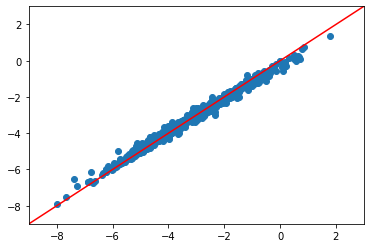

In [ ]:
plt.scatter(train[target], mu)
plt.plot(np.linspace(-9, 3), np.linspace(-9, 3), c = 'r')
plt.xlim(-9, 3)
plt.ylim(-9, 3)
plt.show()

In [ ]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.1026528897885943
RMSE: 0.1559697478035153


In [ ]:
mu_test = gpr_base.predict(test.graphs)

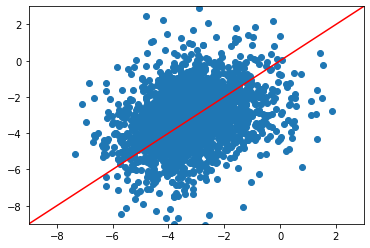

In [ ]:
plt.scatter(test[target], mu_test)
plt.plot(np.linspace(-9, 3), np.linspace(-9, 3), c = 'r')
plt.xlim(-9, 3)
plt.ylim(-9, 3)
plt.show()

In [ ]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 1.3984523944497356
RMSE: 1.7902476214464011


### Model 2

In [ ]:
gpr2 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-5, #different from gpr in alpha where gpr_base alpha is 1e-4
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [ ]:
gpr2.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|  3.9342e+06|  7.4014e+07|  3.9413e+06|     -7048.5|  4.2676e+07|        20|      0.25|
|  2.5581e+06|  4.8127e+07|  2.5648e+06|     -6637.5|   3.185e+07|        19|      0.26|
|  1.9651e+06|  3.6386e+07|  1.9715e+06|     -6391.2|  2.5862e+07|        19|      0.25|
|  1.4839e+06|  2.6275e+07|  1.4901e+06|     -6132.7|  2.0389e+07|        19|      0.25|
|  1.1925e+06|  1.9644e+07|  1.1985e+06|     -5931.7|  1.6716e+07|        18|      0.25|
|  9.9823e+05|  1.5219e+07|   1.004e+06|     -5762.3|  1.4068e+07|        17|      0.25|
|   8.735e+05|  1.2618e+07|  8.7912e+05|     -5627.6|  1.2412e+07|        17|      0.25|
|   8.215e+05|  1.1223e+07|  8.2708e+05|     -5576.1|  1.1158e+07|        16|      0.25|
|  7.7928e+05|  1.0614e+07|  7.8479e+05|     -5517.2|   1.082e+07|        17|      0.25|
|  7.6384e+05|  1.039

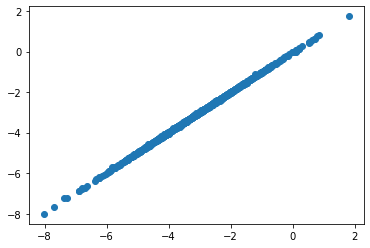

In [ ]:
mu = gpr2.predict(train.graphs)
plt.scatter(train[target], mu)
plt.plot(np.linspace(-9, 3), np.linspace(-9, 3), c = 'r')
plt.xlim(-9, 3)
plt.ylim(-9, 3)
plt.show()

In [ ]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.01420440124959926
RMSE: 0.021649804308151027


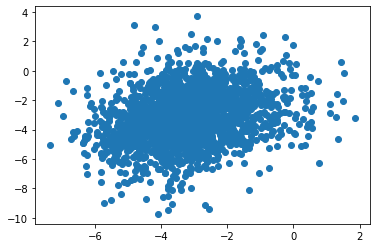

In [ ]:
mu_test = gpr2.predict(test.graphs)
plt.scatter(test[target], mu_test)
plt.plot(np.linspace(-10, 4), np.linspace(-10, 4), c = 'r')
plt.xlim(-10, 4)
plt.ylim(-10, 4)
plt.show()

In [ ]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 1.517212238428167
RMSE: 1.943288841802438


### Model 3

In [12]:
gpr3 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-3, #different from gpr in alpha where gpr_base's alpha is 1e-4
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [13]:
gpr3.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|  5.2754e+05|  1.7773e+06|  5.3362e+05|     -6084.7|  9.0549e+05|        25|      0.28|
|  4.4224e+05|  1.9515e+06|  4.4805e+05|     -5808.2|  8.7902e+05|        20|      0.27|
|  3.1405e+05|  1.8185e+06|  3.1934e+05|     -5298.7|  8.0593e+05|        18|      0.24|
|  2.8469e+05|  1.6176e+06|  2.8985e+05|       -5163|  7.8268e+05|        17|      0.26|
|  2.6118e+05|  1.4683e+06|  2.6622e+05|     -5042.3|  7.5644e+05|        17|      0.24|
|  2.5267e+05|  1.3881e+06|  2.5767e+05|     -4997.8|  7.4692e+05|        16|      0.26|
|   2.496e+05|  1.3914e+06|  2.5458e+05|       -4978|  7.4218e+05|        17|      0.25|
|  2.4851e+05|  1.3833e+06|  2.5349e+05|     -4971.9|  7.4096e+05|        17|      0.25|
|  2.4817e+05|  1.3928e+06|  2.5314e+05|     -4967.6|  7.3437e+05|        17|      0.24|
|  2.4724e+05|  1.377

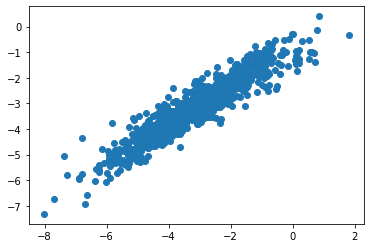

In [14]:
mu = gpr3.predict(train.graphs)
plt.scatter(train[target], mu)
#plt.plot(np.linspace(-9, 3), np.linspace(-9, 3), c = 'r')
#plt.xlim(-9, 3)
#plt.ylim(-9, 3)
plt.show()

In [17]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.3711113759832458
RMSE: 0.5245520571276874


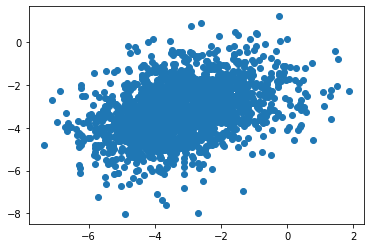

In [16]:
mu_test = gpr3.predict(test.graphs)
plt.scatter(test[target], mu_test)
#plt.plot(np.linspace(-10, 4), np.linspace(-10, 4), c = 'r')
#plt.xlim(-10, 4)
#plt.ylim(-10, 4)
plt.show()

In [18]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 1.1498112446483284
RMSE: 1.4624191158480997


### Model 4

In [19]:
gpr4 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-2, #different from gpr in alpha where gpr_base's alpha is 1e-4
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [20]:
gpr4.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|       66517|       88265|       70813|     -4296.2|       90905|        21|      0.28|
|       61455|  1.0409e+05|       65648|     -4193.5|       88757|        19|      0.25|
|       50869|  1.1321e+05|       54789|     -3920.3|       81573|        17|      0.23|
|       49285|  1.0995e+05|       53162|     -3876.6|       80232|        17|      0.28|
|       48321|  1.0553e+05|       52167|       -3845|       78704|        16|      0.24|
|       47912|  1.0664e+05|       51747|     -3834.9|       78334|        17|      0.25|
|       47815|  1.0611e+05|       51648|     -3832.7|       78473|        17|      0.25|
|       47734|  1.0602e+05|       51565|     -3830.1|       78399|        17|      0.24|
|       47721|   1.056e+05|       51549|     -3828.8|       78754|        17|      0.25|
|       47682|  1.058

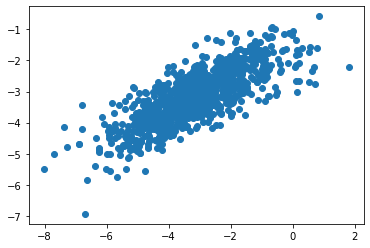

In [21]:
mu = gpr4.predict(train.graphs)
plt.scatter(train[target], mu)
#plt.plot(np.linspace(-9, 3), np.linspace(-9, 3), c = 'r')
#plt.xlim(-9, 3)
#plt.ylim(-9, 3)
plt.show()

In [22]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.6721642416785486
RMSE: 0.9001504628434619


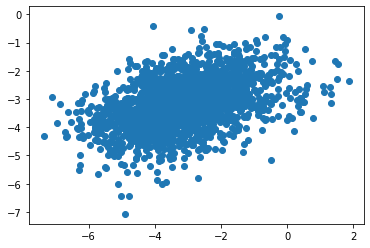

In [23]:
mu_test = gpr4.predict(test.graphs)
plt.scatter(test[target], mu_test)
#plt.plot(np.linspace(-10, 4), np.linspace(-10, 4), c = 'r')
#plt.xlim(-10, 4)
#plt.ylim(-10, 4)
plt.show()

In [24]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 0.996800387138675
RMSE: 1.2687098498475842


### Model 5

In [26]:
gpr5 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-1, #different from gpr in alpha where gpr_base's alpha is 1e-4
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [27]:
gpr5.fit(train.graphs, train[target], repeat=3, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|      5933.5|      3681.9|        8130|     -2196.5|        9095|        23|      0.27|
|      5700.6|      4368.7|      7866.6|       -2166|        8897|        21|      0.23|
|      5244.7|      4143.6|      7321.1|     -2076.4|      8114.4|        17|      0.24|
|      5161.9|      4261.1|      7222.8|       -2061|      8040.9|        17|      0.23|
|      5123.7|      4119.8|      7182.2|     -2058.5|      8116.4|        17|      0.25|
|      5100.9|      4055.4|      7155.4|     -2054.5|      8044.2|        17|      0.25|
|      5081.3|      3976.5|      7132.4|     -2051.1|      7995.7|        17|      0.24|
|      5078.6|      3971.4|      7128.4|     -2049.9|      7991.1|        17|      0.24|
|        5077|      3973.1|      7126.9|     -2049.9|      7990.8|        17|      0.24|
|      5075.4|      3

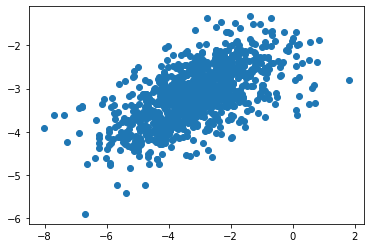

In [28]:
mu = gpr5.predict(train.graphs)
plt.scatter(train[target], mu)
#plt.plot(np.linspace(-9, 3), np.linspace(-9, 3), c = 'r')
#plt.xlim(-9, 3)
#plt.ylim(-9, 3)
plt.show()

In [29]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.8642262237055949
RMSE: 1.1297768774199661


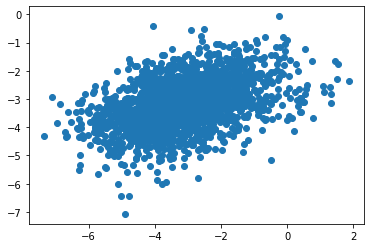

In [30]:
mu_test = gpr4.predict(test.graphs)
plt.scatter(test[target], mu_test)
#plt.plot(np.linspace(-10, 4), np.linspace(-10, 4), c = 'r')
#plt.xlim(-10, 4)
#plt.ylim(-10, 4)
plt.show()

In [31]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 0.9967978325813834
RMSE: 1.2687065452737312
